<a href="https://colab.research.google.com/github/aashgohil/Cohort_Analysis_Python/blob/main/Cohort_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as pyplot


In [2]:
df = pd.read_excel('https://github.com/aashgohil/Cohort_Analysis_Python/blob/main/Online%20Retail.xlsx?raw=true')
df.head()
#Importing the Data, and having a look at it.

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#Cleaning the Data

In [8]:
print("Shape of DF is {}".format(df.shape),'\n')
print("Column Names are {}".format(list(df.columns)),'\n')
print(df.info())

Shape of DF is (541909, 8) 

Column Names are ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country'] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


In [ ]:
df.count()

InvoiceNo      541909
StockCode      541909
Description    540455
Quantity       541909
InvoiceDate    541909
UnitPrice      541909
CustomerID     406829
Country        541909
dtype: int64

In [ ]:
df.isnull().sum()
#Identifying null values.

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
#Drop null values
df = df.dropna(subset=['CustomerID'])

#Checking null values after removal
print(df.isnull().sum(),'\n')

print(df.count())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64 

InvoiceNo      406829
StockCode      406829
Description    406829
Quantity       406829
InvoiceDate    406829
UnitPrice      406829
CustomerID     406829
Country        406829
dtype: int64


#EDA

In [ ]:
#Casting CustomerID as a string
df['CustomerID']= df['CustomerID'].astype(str)

#Inspecting the distribution of quantity and unit price
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,406829.0,12.061303,248.693370,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,406829.0,3.460471,69.315162,0.0,1.25,1.95,3.75,38970.0


In [19]:
#Finding users who ordered multiple times

#Aggregrating cutomer id by unique number of invoice ID's
num_orders = df.groupby('CustomerID').agg({'InvoiceNo':'nunique'})

#Calculating rate of user's who ordered more than once
multi_order_rate = num_orders[num_orders['InvoiceNo'] > 1].count()/num_orders.count()

print('{} percent of people ordered more than once'.format(round(float(multi_order_rate) *100)))

70 percent or people ordered more than once


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


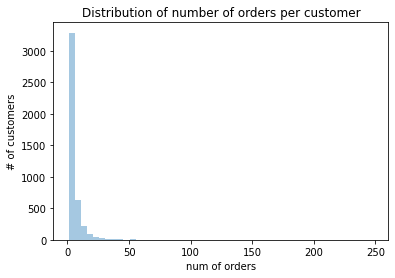

In [39]:
#Visulaling the distribution of number of orders per customer

viz = sns.distplot(num_orders, kde = False)
viz.set(title='Distribution of number of orders per customer',
       xlabel='num of orders', 
       ylabel='# of customers');

#Builiding the Cohort


In [40]:
#Working only with the needed Columns

df=df[['CustomerID', 'InvoiceNo','InvoiceDate']].drop_duplicates()

In [42]:
#Caluclating the month of placing order
df['order_month'] = df['InvoiceDate'].dt.to_period('M')

In [47]:
#Calculating Cohort Month, the month of first purchase of user
df['cohort'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

In [93]:
#Aggregating Data by cohort
df_cohort = df.groupby(['cohort','order_month']).agg(n_customers=('CustomerID','nunique')).reset_index(drop = False)

df_cohort['period_number'] = (df_cohort.order_month.astype(int) - df_cohort.cohort.astype(int))


In [95]:
df_cohort

,cohort,order_month,n_customers,period_number
0,2010-12,2010-12,948,0
1,2010-12,2011-01,362,1
2,2010-12,2011-02,317,2
3,2010-12,2011-03,367,3
4,2010-12,2011-04,341,4
...,...,...,...,...
86,2011-10,2011-11,93,1
87,2011-10,2011-12,46,2
88,2011-11,2011-11,321,0
89,2011-11,2011-12,43,1


In [96]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort', columns = 'period_number', values = 'n_customers')

In [106]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5]), <a list of 13 Text major ticklabel objects>)

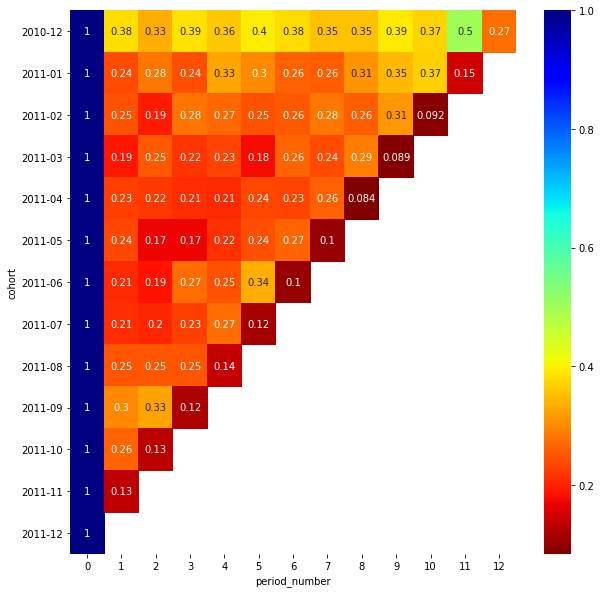

In [138]:
pyplot.figure(figsize=(10,10))
sns.heatmap(retention_matrix, annot = True, cmap ='jet_r')
pyplot.yticks(rotation=0)